# Predicting Drug-Drug Interactions Using the Ogbl-ddi Dataset

Maya Srikanth, Arpita Singhal, and Manasi Sharma
(CS224W Final Project)

In this Colab notebook, we will be investigating drug-drug interactions. We will use the ogbl-ddi dataset, a homogeneous, unweighted, and undirected graph representing a drug-drug interaction network. Each node represents a FDA-approved or experimental drug, and the edges represent interactions between drugs. The edges may indicate that the effect of simultaneously taking two drugs is quite different from the effect expected when the drugs act independently.

Given information on previously-known drug-drug interactions, we aim to predict new drug-drug interactions. Our model will rank each true drug-drug interaction among a set of randomly-sampled negative drug interactions. We will use Hits@K to evaluate performance: this counts the ratio of positive edges (edges that exist in the graph) that the model ranks at K-place or above. Note that this is a transductive link prediction task: this means that our training, validation and test sets will contain all nodes in the graph, but will contain different subsets of edges. Each of the train, validation, and test sets will also have held-out ("supervision") edges: ultimately, we want to train our model to predict the existence of these supervision edges! 

A lot of the code seen in this colab was adapted from the Github repository in the OGB Dataset Paper [1]. 

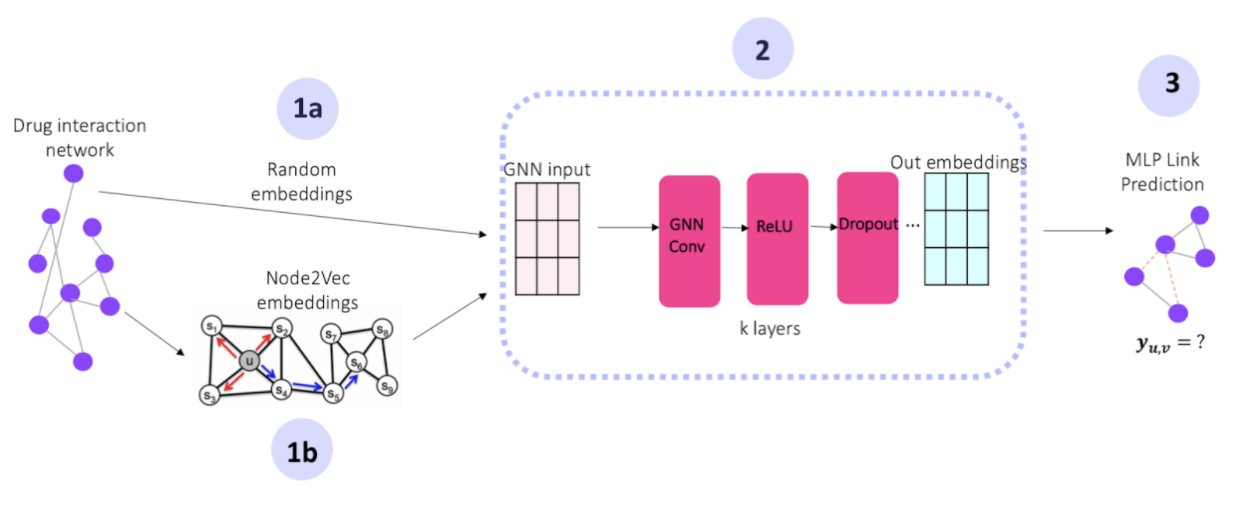

**Roadmap**. 1 corresponds to the drug interaction network, 2a and 2b correspond to preprocessing, 2 corresponds to  graph neural network models, and 3 corresponds to the final network responsible for link prediction. In this notebook, we will be walking you through the implementation of this pipeline.

# PLEASE NOTE: **This colab is meant to be run on GCP.** Before running any cells in this notebook, please create an empty directory called "training_outputs" in the same directory you are running this notebook. We implemented using a GCP instance, and the code in this Colab assumes that model checkpoints and embedding checkpoints are outputted to this directory!

## Setup

In [ ]:
%%capture 

# Installing the packages required for importing our dataset, creating our GCN 
# models, and evaluating the models.
# UNCOMMENT AND RUN THE FOLLOOWING COMMANDS IF if you don't have these packages installed!

# If these packages are not already installed, please run the following lines.

# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
# !pip install torch-geometric
# !pip install -q git+https://github.com/snap-stanford/deepsnap.git

# !pip install ogb


In [ ]:
# Importing necessary dependencies in order to import our dataset, create our 
# GCN models, and evaluate the models

import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU

from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data

import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GINConv, GATConv

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
from torch_geometric.data import DataLoader

from torch_geometric.nn import Node2Vec

import pandas as pd
import shutil, os
import os.path as osp
import numpy as np

#from logger import Logger
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

Device: cuda


## Preprocessing: Node2Vec [2]

Node2Vec uses a biased random walk parameterized by p and q, where p controls the probability of returning back to the previous node and q controls whether to move outward (in a DFS-like manner) versus inward (in a BFS-like manner). The algorithm simulates a fixed number of random walks of fixed length starting from each node in order to compute the random walk probabilities for each transition, and then optimizing the embeddings using Stochastic Gradient Descent such that nodes with similar network neighbors are close in the feature space. Due to its combined breadth-first and depth-first strategy, the Node2Vec embeddings can encode both local and global neighborhood network features, which is important for our task as the proximity of a drug to its neighbors can indicate potential drug interactions that drug also has.

In [ ]:
def save_embedding(model, filepath): # function to save embedding to specified filepath
    torch.save(model.embedding.weight.data.cpu(), filepath) 

In [ ]:
# training function for node2vec using PyG's Node2Vec function
def train_Node2Vec(args, data, filepath):
  model = Node2Vec(data.edge_index, args['embedding_dim'], args['walk_length'],
                    args['context_size'], args['walks_per_node'],
                    sparse=True).to(device)

  loader = model.loader(batch_size=args['batch_size'], shuffle=True,
                        num_workers=4)
  optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=args['lr'])

  model.train()
  for epoch in range(1, args['epochs'] + 1):
      for i, (pos_rw, neg_rw) in enumerate(loader):
          optimizer.zero_grad()
          loss = model.loss(pos_rw.to(device), neg_rw.to(device))
          loss.backward()
          optimizer.step()

          if (i + 1) % args['log_steps'] == 0:
              print(f'Epoch: {epoch:02d}, Step: {i+1:03d}/{len(loader)}, '
                    f'Loss: {loss:.4f}')

          if (i + 1) % 100 == 0:  # Save model every 100 steps.
              save_embedding(model, filepath)
      save_embedding(model, filepath)


## Graph Neural Networks

We can turn to graph neural networks to generate more expressive node representations. There are 3 key steps to any graph convolutional layer, and we’ll cover them below: message, aggregate, and update.

**Message**: Each node creates a “message”, containing information that it wants to pass to its neighboring nodes. At a given layer (*l*), the message (*m*) computed by node u is some linear transformation of its node representation (h) produced by the last graph convolutional layer (*l* - 1). 
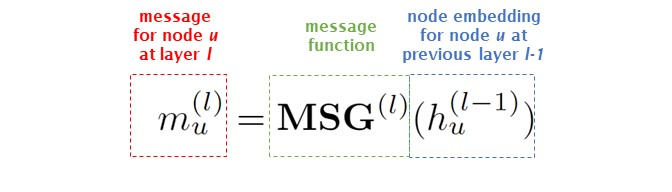


**Aggregate**: Each node then aggregates the messages from all of its neighbors. Crucially, this step propagates  information through the network. 
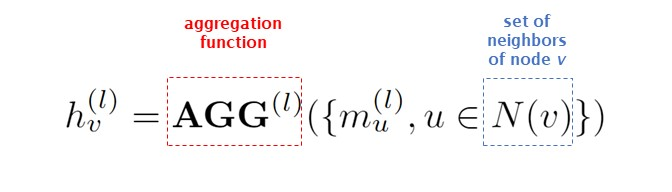

**Update**: The takes the outputs from the aggregation step to produce the final node embedding representation for a given node *u*. In order to preserve information from the previous layer embedding, we’ll often concatenate a given node’s message to itself to the aggregation output. Other variations of the update function include a non-linear transformation (like ReLu) to the output of ‘CONCAT’. 


## Graph Convolutional Network (GCN) Model Class [3]

In [ ]:
# class using PyG's GCNConv layer
class GCN(torch.nn.Module):
  ''' Define GCN network. '''
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, cached=True))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        # Execute conv -> relu -> dropout sequence
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x


## GraphSAGE Model Class [4]

In [ ]:
# class using PyG's SAGEConv layer
class SAGE(torch.nn.Module):
  ''' Define GCN network. '''
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
      # Execute conv -> relu -> dropout sequence
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x

## Graph Isomorphic Network (GIN) Class [5]

In [ ]:
# class using PyG's GINConv layer
class GIN(torch.nn.Module):
  ''' Define graph isomorphic network. '''
    def __init__(self, in_channels, dim, out_channels, num_layers,
                 dropout):
        super().__init__()
         # # Initialize 2 GINConv layers (following num_layers=2 in model-agnostic hyperparams as specified in the blogpost)
        self.conv1 = GINConv(
            Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU())) # GINConv takes a neural network as input

        self.conv2 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))
        
        self.dropout = dropout
  
    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()


    def forward(self, x, adj_t):
       # Execute conv -> relu -> dropout sequence
        x = self.conv1(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, adj_t)
        return x

## Link Predictor Class

To formulate a sensible prediction task, we need to understand the concept of positive vs. negative edges. Positive edges are edges that exist in the graph (they indicate a drug-drug interaction), while negative edges are edges that do not exist in the graph but are created by simulation for testing purposes. 

We then use a Link Predictor on the set of positive edges and negative edges. In order to design the Link Predictor, we can take two embeddings corresponding to two nodes *u*, *v* in the graph and feed their product through a neural network. This network will apply a series of linear and non-linear transformations to its input, finally using a sigmoid function to output the probability that the edge (*u*, *v*) exists in the graph.

In [ ]:
# class in order to predict whether a link exists between two nodes using 
# their embeddings, x_i and x_j
class LinkPredictor(torch.nn.Module):
    ''' Neural network which predicts whether a link (interaction) exists between 2 nodes i,j 
    given their embeddings x_i, x_j. 
    '''
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j # hadamard product
        for lin in self.lins[:-1]: # linear layer -> relu -> dropout
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x) # sigmoid activation outputs probability that a given edge exists for all node pairs

## Train Workflow and Evaluation 

In [ ]:
def train(model, predictor, x, adj_t, split_edge, optimizer, batch_size):

    row, col, _ = adj_t.coo()
    edge_index = torch.stack([col, row], dim=0)

    model.train()
    predictor.train()

    pos_train_edge = split_edge['train']['edge'].to(x.device)

    total_loss = total_examples = 0
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size,
                           shuffle=True):
        optimizer.zero_grad()

        h = model(x, adj_t)

        edge = pos_train_edge[perm].t()

        # computes the loss for positive edges
        pos_out = predictor(h[edge[0]], h[edge[1]])
        pos_loss = -torch.log(pos_out + 1e-15).mean()

        # samples negative edges from the graph
        edge = negative_sampling(edge_index, num_nodes=x.size(0),
                                 num_neg_samples=perm.size(0), method='dense')

        # computes the loss for negative edges
        neg_out = predictor(h[edge[0]], h[edge[1]])
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(x, 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

        optimizer.step()

        num_examples = pos_out.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples


@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size):
    model.eval()
    predictor.eval()

    h = model(x, adj_t)

    pos_train_edge = split_edge['eval_train']['edge'].to(x.device)
    pos_valid_edge = split_edge['valid']['edge'].to(x.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(x.device)
    pos_test_edge = split_edge['test']['edge'].to(x.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(x.device)

    # store what the link predictor outputs for each positive and negative 
    # edge in order to compute the hits@K
    pos_train_preds = []
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size):
        edge = pos_train_edge[perm].t()
        pos_train_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_train_pred = torch.cat(pos_train_preds, dim=0)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    # compute the hits@K for training, validation, and test
    results = {}
    for K in [10, 20]: 
        evaluator.K = K
        train_hits = evaluator.eval({
            'y_pred_pos': pos_train_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)

    return results

## Training Pipeline

## Load Model-agnostic data (graph, edge splits)

In [ ]:
# loaded with transform parameter set as such in order to obtain the adj_t matrix
# required for the GNN layers
dataset = PygLinkPropPredDataset(name='ogbl-ddi',
                                     transform=T.ToSparseTensor()) # loading ogb-ddi 
print('Task type: {}'.format(dataset.task_type))
graph = dataset[0] 
adj_t = graph.adj_t.to(device) # loads all edges in graph into sparse adj_t matrix

Task type: link prediction


In [ ]:
# dataset reloaded without the transform parameter to obtain the data in the 
# correct format
dataset = PygLinkPropPredDataset(name='ogbl-ddi')
data = dataset[0]

In [ ]:
# getting the train, validation, and test edge splits
split_edge = dataset.get_edge_split()
train_edges = split_edge['train']['edge']
torch.manual_seed(70) # picking random samples to evaluate on 
idx = torch.randperm(split_edge['train']['edge'].size(0))
idx = idx[:split_edge['valid']['edge'].size(0)]
split_edge['eval_train'] = {'edge': split_edge['train']['edge'][idx]}

## Set GNN hyperparameters

In [ ]:
gnn_args = { # define GNN hyperparams
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 256,
    'dropout': 0.5,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.005,
    'attn_size': 32,
    'num_layers':2,
    'log_steps':1,
    'eval_steps':5,
    'runs':10,
    'batch_size': 64*1024,

}

## Node2Vec as initial weights for GNN (trained on train split edges)

In [ ]:
train_edges_node2vec = train_edges.T # transpose to get the right dimension 
# Initialize edge-induced subgraph with only train edges (edge-induced subgraph)
data_node2vec = Data(edge_index=train_edges_node2vec)

In [ ]:
train_node2vec = True # change to true if you'd like to train/retrain embeddings

In [ ]:
  # Train Node2Vec on the train edge-induced subgraph 
  filepath = 'training_outputs/train-embedding-256.pt'
  node2vec_args = {'device':0, 'embedding_dim':256, 'walk_length':40, 'context_size':20, 'walks_per_node':10,
      'batch_size':256, 'lr':0.01, 'epochs':100, 'log_steps':1}
  train_Node2Vec(node2vec_args, data_node2vec, filepath) # embeddings will save to specified filepath

/opt/conda/envs/project3/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01, Step: 001/17, Loss: 9.5281
Epoch: 01, Step: 002/17, Loss: 9.2534
Epoch: 01, Step: 003/17, Loss: 9.0809
Epoch: 01, Step: 004/17, Loss: 8.8701
Epoch: 01, Step: 005/17, Loss: 8.7928
Epoch: 01, Step: 006/17, Loss: 8.6826
Epoch: 01, Step: 007/17, Loss: 8.5681
Epoch: 01, Step: 008/17, Loss: 8.5090
Epoch: 01, Step: 009/17, Loss: 8.3808
Epoch: 01, Step: 010/17, Loss: 8.3454
Epoch: 01, Step: 011/17, Loss: 8.1972
Epoch: 01, Step: 012/17, Loss: 8.1725
Epoch: 01, Step: 013/17, Loss: 8.0843
Epoch: 01, Step: 014/17, Loss: 8.0202
Epoch: 01, Step: 015/17, Loss: 7.9952
Epoch: 01, Step: 016/17, Loss: 7.8649
Epoch: 01, Step: 017/17, Loss: 7.8629
Epoch: 02, Step: 001/17, Loss: 7.7669
Epoch: 02, Step: 002/17, Loss: 7.6957
Epoch: 02, Step: 003/17, Loss: 7.6650
Epoch: 02, Step: 004/17, Loss: 7.6060
Epoch: 02, Step: 005/17, Loss: 7.5913
Epoch: 02, Step: 006/17, Loss: 7.4867
Epoch: 02, Step: 007/17, Loss: 7.4080
Epoch: 02, Step: 008/17, Loss: 7.4304
Epoch: 02, Step: 009/17, Loss: 7.3595
Epoch: 02, S

In [ ]:
# load embeddings from node2vec as initial features for gnn model
filepath = 'training_outputs/train-embedding-256.pt'
pretrained_weight = torch.load(filepath, map_location='cpu').to(device)
pretrained_weight = pretrained_weight.cpu().data.numpy()
node2vec_emb = torch.nn.Embedding(dataset.data.num_nodes, gnn_args['hidden_size']).to(device)
# pretrained_weight is a numpy matrix of shape (num_embeddings, embedding_dim)
node2vec_emb.weight.data.copy_(torch.from_numpy(pretrained_weight))

tensor([[ 0.3224, -0.0795, -0.1747,  ..., -0.3780,  0.0849,  0.1163],
        [-0.0217, -0.0416, -0.0083,  ..., -0.0121, -0.0512, -0.0284],
        [ 0.1921,  0.0520, -0.0681,  ..., -0.1204, -0.4229, -0.2286],
        ...,
        [ 0.0666,  0.0089,  0.0060,  ...,  0.0469,  0.0498, -0.0125],
        [ 0.0241,  0.1070, -0.0561,  ...,  0.0212, -0.0022,  0.0482],
        [-0.0137, -0.0435, -0.0640,  ..., -0.0189,  0.0480,  0.0418]],
       device='cuda:0')

In [ ]:
node2vec_emb.weight.shape # should be 4267x256

torch.Size([4267, 256])

## Training Function 

In [ ]:
def train_model(model, emb, gnn_args, predictor, model_name): 
  ''' 
  Train specified GNN model. Model and embeddings should be initialized. 
  Save model after every run. 
  '''
  train_hits_arr, val_hits_arr, test_hits_arr = [], [], []
  
  evaluator = Evaluator(name='ogbl-ddi')
  for run in range(2):
    max_valhits, train_hits_run, test_hits_run = float('-inf'), 0, 0
    
    torch.nn.init.xavier_uniform_(emb.weight)
    model.reset_parameters()
    predictor.reset_parameters()
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(emb.parameters()) +
        list(predictor.parameters()), lr=gnn_args['lr'])

    for epoch in range(1, 1 + gnn_args['epochs']):
        loss = train(model, predictor, emb.weight, adj_t, split_edge,
                      optimizer, gnn_args['batch_size'])

        if epoch % gnn_args['eval_steps'] == 0:
            results = test(model, predictor, emb.weight, adj_t, split_edge,
                            evaluator, gnn_args['batch_size'])
            

            if epoch % gnn_args['log_steps'] == 0:
                for key, result in results.items():
                    train_hits, valid_hits, test_hits = result
                    print(key)
                    print(f'Run: {run + 1:02d}, '
                          f'Epoch: {epoch:02d}, '
                          f'Loss: {loss:.4f}, '
                          f'Train: {100 * train_hits:.2f}%, '
                          f'Valid: {100 * valid_hits:.2f}%, '
                          f'Test: {100 * test_hits:.2f}%')
                print('---')
    
            # check val-hits@20
            train_hits, valid_hits, test_hits = results['Hits@20']
            if valid_hits >= max_valhits: # if validhits20 is higher than max, save ckpt               
              max_valhits = valid_hits
              train_hits_run = train_hits
              test_hits_run = test_hits
              # Save model checkpoint for current run.
              model_path = f"training_outputs/{model_name}.pt"
              emb_path = f'training_outputs/{model_name}_init_emb.pt'
              save_model_ckpt(model, emb, optimizer, predictor, loss, emb_path, model_path)
    train_hits_arr.append(train_hits_run)
    test_hits_arr.append(test_hits_run)
    val_hits_arr.append(max_valhits)


  # Print overall stats arrays for best model based on val hits@20
  print("Val_hits@20: ", val_hits_arr)
  print("Test_hits@20: ", test_hits_arr)
  print("Train_hits@20: ", train_hits_arr)

  # Print best model stats (based on val hits@20)
  val_max = max(val_hits_arr)
  print("Best model val hits@20: ", max(val_hits_arr))
  max_idx = val_hits_arr.index(val_max)
  print('Best model test hits@20: ', test_hits_arr[max_idx])
  print('Best model train hits@20: ', val_hits_arr[max_idx])

  # convert to numpy array
  val_hits_arr = np.array(val_hits_arr)
  test_hits_arr = np.array(test_hits_arr)
  train_hits_arr = np.array(train_hits_arr)

  # Print average stats + variance
  print(f"Average best train hits@20: {np.mean(train_hits_arr)}; var: {np.var(train_hits_arr)}")
  print(f"Average best val hits@20: {np.mean(val_hits_arr)}; var: {np.var(val_hits_arr)}")
  print(f"Average best test hits@20: {np.mean(test_hits_arr)}; var: {np.var(test_hits_arr)}")

In [ ]:
def save_model_ckpt(model, emb, optimizer, predictor, loss, emb_path, model_path):
  ''' Save model and embedding checkpoints. '''
  EPOCH = 100
  # Save model params
  torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'predictor_state_dict': predictor.state_dict(),
            'loss': loss,
            }, model_path)  
  # Also save initial embedding (just in case)
  torch.save(emb.weight.data.cpu(), emb_path)

In [ ]:
def load_model_ckpt(curr_model, model_name, run):
  ''' Load model checkpoint. '''
  evaluator = Evaluator(name='ogbl-ddi')
  model_path = f"training_outputs/{model_name}.pt"
  emb_path = f'training_outputs/{model_name}_init_emb.pt'

  # Load emb (init feature representations)
  pretrained_weight = torch.load(emb_path, map_location='cpu').to(device)
  pretrained_weight = pretrained_weight.cpu().data.numpy()
  emb_after = torch.nn.Embedding(dataset.data.num_nodes, gnn_args['hidden_size']).to(device)
  # Pretrained_weight is a numpy matrix of shape (num_embeddings, embedding_dim)
  emb_after.weight.data.copy_(torch.from_numpy(pretrained_weight))

  # Init optimizer and predictor objects 
  predictor = LinkPredictor(gnn_args['hidden_size'], gnn_args['hidden_size'], 1,
                          gnn_args['num_layers'], gnn_args['dropout']).to(device)
  optimizer = torch.optim.Adam(
        list(curr_model.parameters()) + list(emb_after.parameters()) +
        list(predictor.parameters()), lr=gnn_args['lr'])


  # Load model, predictor, and optimizer params
  checkpoint = torch.load(model_path)
  curr_model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  predictor.load_state_dict(checkpoint['predictor_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  # Save final embedding representation of all nodes 
  h = curr_model(emb_after.weight, adj_t)
  final_emb_path = f'training_outputs/{model_name}_final_emb_{run}.pt'
  torch.save(h, final_emb_path)

  # Evaluate pretrained model 
  results = test(curr_model, predictor, emb_after.weight, adj_t, split_edge,
                               evaluator, gnn_args['batch_size'])

  # Print hits stats
  for key, result in results.items():
    print(key)
    train_hits, valid_hits, test_hits = result
    print(f'Train: {100 * train_hits:.2f}%, '
                              f'Valid: {100 * valid_hits:.2f}%, '
                              f'Test: {100 * test_hits:.2f}%')

## Define Models

### Training GraphSAGE

In [ ]:
# TRAIN GRAPHSAGE with random features
model_name = 'sage_rand_feat'
sage_model = SAGE(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
              gnn_args['num_layers'], gnn_args['dropout']).to(device)  
predictor = LinkPredictor(gnn_args['hidden_size'], gnn_args['hidden_size'], 1,
                          gnn_args['num_layers'], gnn_args['dropout']).to(device)
sage_emb_rand = torch.nn.Embedding(dataset.data.num_nodes, gnn_args['hidden_size']).to(device)
train_model(sage_model, sage_emb_rand, gnn_args, predictor, 'sage_rand_feat')

Hits@10
Run: 01, Epoch: 05, Loss: 0.5681, Train: 7.96%, Valid: 7.02%, Test: 3.99%
Hits@20
Run: 01, Epoch: 05, Loss: 0.5681, Train: 11.21%, Valid: 9.89%, Test: 8.96%
---
Hits@10
Run: 01, Epoch: 10, Loss: 0.4053, Train: 20.11%, Valid: 17.45%, Test: 4.50%
Hits@20
Run: 01, Epoch: 10, Loss: 0.4053, Train: 26.75%, Valid: 23.45%, Test: 7.10%
---
Hits@10
Run: 01, Epoch: 15, Loss: 0.3232, Train: 29.87%, Valid: 25.80%, Test: 8.48%
Hits@20
Run: 01, Epoch: 15, Loss: 0.3232, Train: 36.69%, Valid: 32.11%, Test: 13.24%
---
Hits@10
Run: 01, Epoch: 20, Loss: 0.2849, Train: 42.40%, Valid: 36.67%, Test: 17.08%
Hits@20
Run: 01, Epoch: 20, Loss: 0.2849, Train: 49.34%, Valid: 43.10%, Test: 23.84%
---
Hits@10
Run: 01, Epoch: 25, Loss: 0.2598, Train: 47.49%, Valid: 41.04%, Test: 19.62%
Hits@20
Run: 01, Epoch: 25, Loss: 0.2598, Train: 53.41%, Valid: 46.51%, Test: 27.24%
---
Hits@10
Run: 01, Epoch: 30, Loss: 0.2386, Train: 51.21%, Valid: 44.18%, Test: 24.38%
Hits@20
Run: 01, Epoch: 30, Loss: 0.2386, Train: 57.7

In [ ]:
# Loading pretrained graphsage (random weight init) [model with best tests hits@20]
sage_model = SAGE(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)


load_model_ckpt(sage_model, 'sage_rand_feat',0)

Hits@10
Train: 69.24%, Valid: 59.80%, Test: 25.39%
Hits@20
Train: 73.10%, Valid: 63.50%, Test: 39.31%


In [ ]:
# Train GraphSAGE with node2vec = 256 features 
model_name = 'sage_node2vec_feat_256'  
sage_model = SAGE(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)

predictor = LinkPredictor(gnn_args['hidden_size'], gnn_args['hidden_size'], 1,
                          gnn_args['num_layers'], gnn_args['dropout']).to(device)
sage_emb_node2vec = torch.nn.Embedding(dataset.data.num_nodes, gnn_args['hidden_size']).to(device)
sage_emb_node2vec.weight.data.copy_(torch.from_numpy(pretrained_weight))
train_model(sage_model, sage_emb_node2vec, gnn_args, predictor, 'sage_node2vec_feat_256')

Hits@10
Run: 01, Epoch: 05, Loss: 0.5600, Train: 11.37%, Valid: 9.95%, Test: 4.07%
Hits@20
Run: 01, Epoch: 05, Loss: 0.5600, Train: 17.08%, Valid: 15.18%, Test: 11.83%
---
Hits@10
Run: 01, Epoch: 10, Loss: 0.3879, Train: 22.08%, Valid: 19.20%, Test: 6.55%
Hits@20
Run: 01, Epoch: 10, Loss: 0.3879, Train: 29.28%, Valid: 25.87%, Test: 9.63%
---
Hits@10
Run: 01, Epoch: 15, Loss: 0.3253, Train: 25.57%, Valid: 21.78%, Test: 7.44%
Hits@20
Run: 01, Epoch: 15, Loss: 0.3253, Train: 32.88%, Valid: 28.09%, Test: 16.04%
---
Hits@10
Run: 01, Epoch: 20, Loss: 0.2843, Train: 34.23%, Valid: 29.14%, Test: 10.09%
Hits@20
Run: 01, Epoch: 20, Loss: 0.2843, Train: 42.48%, Valid: 36.66%, Test: 17.56%
---
Hits@10
Run: 01, Epoch: 25, Loss: 0.2595, Train: 34.10%, Valid: 28.35%, Test: 10.60%
Hits@20
Run: 01, Epoch: 25, Loss: 0.2595, Train: 48.33%, Valid: 41.28%, Test: 16.06%
---
Hits@10
Run: 01, Epoch: 30, Loss: 0.2417, Train: 49.05%, Valid: 42.19%, Test: 22.91%
Hits@20
Run: 01, Epoch: 30, Loss: 0.2417, Train: 5

In [ ]:
# Loading pretrained graphsage (init features are 256-dim node2vec)
sage_model = SAGE(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)


load_model_ckpt(sage_model, 'sage_node2vec_feat_256',0)

Hits@10
Train: 63.96%, Valid: 54.37%, Test: 45.02%
Hits@20
Train: 73.59%, Valid: 63.79%, Test: 54.01%


### Training GCN

In [ ]:
# TRAIN GCN with random features 
gcn_model = GCN(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)
predictor = LinkPredictor(gnn_args['hidden_size'], gnn_args['hidden_size'], 1,
                          gnn_args['num_layers'], gnn_args['dropout']).to(device)
gcn_emb_rand = torch.nn.Embedding(dataset.data.num_nodes, gnn_args['hidden_size']).to(device)
train_model(gcn_model, gcn_emb_rand, gnn_args, predictor, 'gcn_rand_feat')

Hits@10
Run: 01, Epoch: 05, Loss: 0.6890, Train: 4.83%, Valid: 4.20%, Test: 0.34%
Hits@20
Run: 01, Epoch: 05, Loss: 0.6890, Train: 9.30%, Valid: 8.18%, Test: 5.88%
---
Hits@10
Run: 01, Epoch: 10, Loss: 0.5253, Train: 18.54%, Valid: 16.45%, Test: 9.88%
Hits@20
Run: 01, Epoch: 10, Loss: 0.5253, Train: 23.87%, Valid: 21.57%, Test: 17.49%
---
Hits@10
Run: 01, Epoch: 15, Loss: 0.4429, Train: 19.57%, Valid: 17.35%, Test: 11.74%
Hits@20
Run: 01, Epoch: 15, Loss: 0.4429, Train: 24.61%, Valid: 21.94%, Test: 16.52%
---
Hits@10
Run: 01, Epoch: 20, Loss: 0.4021, Train: 21.97%, Valid: 19.44%, Test: 9.73%
Hits@20
Run: 01, Epoch: 20, Loss: 0.4021, Train: 24.67%, Valid: 21.89%, Test: 14.61%
---
Hits@10
Run: 01, Epoch: 25, Loss: 0.3643, Train: 23.33%, Valid: 20.47%, Test: 10.17%
Hits@20
Run: 01, Epoch: 25, Loss: 0.3643, Train: 28.42%, Valid: 25.17%, Test: 17.66%
---
Hits@10
Run: 01, Epoch: 30, Loss: 0.3413, Train: 21.37%, Valid: 18.59%, Test: 5.55%
Hits@20
Run: 01, Epoch: 30, Loss: 0.3413, Train: 28.38

In [ ]:
# Loading pretrained GCN (random weight init)
gcn_model = GCN(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)
load_model_ckpt(gcn_model, 'gcn_rand_feat',0)

Hits@10
Train: 31.60%, Valid: 27.07%, Test: 13.63%
Hits@20
Train: 45.65%, Valid: 39.54%, Test: 23.39%


In [ ]:
# Train GCN with Node2Vec features
model_name = 'gcn_node2vec_feat_256'  
gcn_model = GCN(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)

predictor = LinkPredictor(gnn_args['hidden_size'], gnn_args['hidden_size'], 1,
                          gnn_args['num_layers'], gnn_args['dropout']).to(device)
gcn_emb_node2vec = torch.nn.Embedding(dataset.data.num_nodes, gnn_args['hidden_size']).to(device)
gcn_emb_node2vec.weight.data.copy_(torch.from_numpy(pretrained_weight))
train_model(gcn_model, gcn_emb_node2vec, gnn_args, predictor, 'gcn_node2vec_feat_256')

Hits@10
Run: 01, Epoch: 05, Loss: 0.6638, Train: 9.54%, Valid: 8.20%, Test: 4.19%
Hits@20
Run: 01, Epoch: 05, Loss: 0.6638, Train: 13.34%, Valid: 11.76%, Test: 7.10%
---
Hits@10
Run: 01, Epoch: 10, Loss: 0.5193, Train: 19.80%, Valid: 17.71%, Test: 12.29%
Hits@20
Run: 01, Epoch: 10, Loss: 0.5193, Train: 23.40%, Valid: 21.17%, Test: 16.15%
---
Hits@10
Run: 01, Epoch: 15, Loss: 0.4377, Train: 22.43%, Valid: 20.08%, Test: 11.01%
Hits@20
Run: 01, Epoch: 15, Loss: 0.4377, Train: 25.16%, Valid: 22.65%, Test: 16.63%
---
Hits@10
Run: 01, Epoch: 20, Loss: 0.3819, Train: 16.46%, Valid: 14.30%, Test: 5.85%
Hits@20
Run: 01, Epoch: 20, Loss: 0.3819, Train: 22.62%, Valid: 20.06%, Test: 18.78%
---
Hits@10
Run: 01, Epoch: 25, Loss: 0.3578, Train: 18.94%, Valid: 16.41%, Test: 6.37%
Hits@20
Run: 01, Epoch: 25, Loss: 0.3578, Train: 25.06%, Valid: 22.06%, Test: 14.42%
---
Hits@10
Run: 01, Epoch: 30, Loss: 0.3383, Train: 16.80%, Valid: 14.60%, Test: 4.28%
Hits@20
Run: 01, Epoch: 30, Loss: 0.3383, Train: 27.

In [ ]:
# Loading GCN trained on Node2Vec Features
gcn_model = GCN(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)
load_model_ckpt(gcn_model, 'gcn_node2vec_feat_256',0)

Hits@10
Train: 26.21%, Valid: 22.02%, Test: 12.17%
Hits@20
Train: 47.53%, Valid: 41.24%, Test: 27.46%


## Training GIN

In [ ]:
# Train GIN with random features
gin_model = GIN(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)

predictor = LinkPredictor(gnn_args['hidden_size'], gnn_args['hidden_size'], 1,
                          gnn_args['num_layers'], gnn_args['dropout']).to(device)
gin_emb_rand = torch.nn.Embedding(dataset.data.num_nodes, gnn_args['hidden_size']).to(device)
train_model(gin_model, gin_emb_rand, gnn_args, predictor, 'gin_rand_feat')

Hits@10
Run: 01, Epoch: 05, Loss: 0.5255, Train: 3.66%, Valid: 3.06%, Test: 2.05%
Hits@20
Run: 01, Epoch: 05, Loss: 0.5255, Train: 5.30%, Valid: 4.34%, Test: 2.82%
---
Hits@10
Run: 01, Epoch: 10, Loss: 0.4528, Train: 23.76%, Valid: 21.18%, Test: 20.80%
Hits@20
Run: 01, Epoch: 10, Loss: 0.4528, Train: 33.86%, Valid: 30.79%, Test: 26.98%
---
Hits@10
Run: 01, Epoch: 15, Loss: 0.3946, Train: 23.15%, Valid: 21.18%, Test: 20.28%
Hits@20
Run: 01, Epoch: 15, Loss: 0.3946, Train: 26.73%, Valid: 25.03%, Test: 24.14%
---
Hits@10
Run: 01, Epoch: 20, Loss: 0.3545, Train: 21.72%, Valid: 18.92%, Test: 20.86%
Hits@20
Run: 01, Epoch: 20, Loss: 0.3545, Train: 31.89%, Valid: 28.23%, Test: 26.00%
---
Hits@10
Run: 01, Epoch: 25, Loss: 0.3244, Train: 21.35%, Valid: 18.50%, Test: 13.12%
Hits@20
Run: 01, Epoch: 25, Loss: 0.3244, Train: 33.13%, Valid: 28.99%, Test: 23.56%
---
Hits@10
Run: 01, Epoch: 30, Loss: 0.2977, Train: 34.21%, Valid: 29.95%, Test: 26.68%
Hits@20
Run: 01, Epoch: 30, Loss: 0.2977, Train: 43

In [ ]:
# Load GIN with random features
gin_model = GIN(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)
load_model_ckpt(gin_model, 'gin_rand_feat',0)

Hits@10
Train: 32.15%, Valid: 27.26%, Test: 35.29%
Hits@20
Train: 53.26%, Valid: 46.36%, Test: 51.51%


In [ ]:
# Train GIN with Node2Vec Features
gin_simple = GIN(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)

predictor = LinkPredictor(gnn_args['hidden_size'], gnn_args['hidden_size'], 1,
                          gnn_args['num_layers'], gnn_args['dropout']).to(device)
gcn_emb_node2vec = torch.nn.Embedding(dataset.data.num_nodes, gnn_args['hidden_size']).to(device)
gcn_emb_node2vec.weight.data.copy_(torch.from_numpy(pretrained_weight))
train_model(gin_model, gin_emb_rand, gnn_args, predictor, 'gin_node2vec_feat_256')

/opt/conda/envs/project3/lib/python3.7/site-packages/torch_geometric/data/storage.py:249: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")
/opt/conda/envs/project3/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Hits@10
Run: 01, Epoch: 05, Loss: 0.5041, Train: 3.54%, Valid: 2.96%, Test: 4.91%
Hits@20
Run: 01, Epoch: 05, Loss: 0.5041, Train: 7.49%, Valid: 6.45%, Test: 6.78%
---
Hits@10
Run: 01, Epoch: 10, Loss: 0.4199, Train: 13.40%, Valid: 11.66%, Test: 7.32%
Hits@20
Run: 01, Epoch: 10, Loss: 0.4199, Train: 19.49%, Valid: 17.17%, Test: 10.62%
---
Hits@10
Run: 01, Epoch: 15, Loss: 0.3738, Train: 15.16%, Valid: 13.00%, Test: 11.67%
Hits@20
Run: 01, Epoch: 15, Loss: 0.3738, Train: 22.93%, Valid: 20.19%, Test: 14.29%
---
Hits@10
Run: 01, Epoch: 20, Loss: 0.3355, Train: 26.25%, Valid: 22.76%, Test: 18.96%
Hits@20
Run: 01, Epoch: 20, Loss: 0.3355, Train: 33.31%, Valid: 29.16%, Test: 28.28%
---
Hits@10
Run: 01, Epoch: 25, Loss: 0.3057, Train: 9.92%, Valid: 8.33%, Test: 12.33%
Hits@20
Run: 01, Epoch: 25, Loss: 0.3057, Train: 16.04%, Valid: 13.58%, Test: 17.56%
---
Hits@10
Run: 01, Epoch: 30, Loss: 0.2858, Train: 3.53%, Valid: 2.91%, Test: 7.98%
Hits@20
Run: 01, Epoch: 30, Loss: 0.2858, Train: 4.86%, V

In [ ]:
# load GIN with Node2Vec Features
gin_model = GIN(gnn_args['hidden_size'], gnn_args['hidden_size'], gnn_args['hidden_size'], 
             gnn_args['num_layers'], gnn_args['dropout']).to(device)
load_model_ckpt(gin_model, 'gin_node2vec_feat_256',0)

Hits@10
Train: 44.88%, Valid: 38.61%, Test: 45.10%
Hits@20
Train: 53.78%, Valid: 46.80%, Test: 56.14%


### TSNE Plotting Code

In [ ]:
# Randomly sample 2k training edges 
tsne_edges_train = split_edge['train']['edge']
tsne_edges_train = tsne_edges_train.T
train_edge_tuples = list(zip(tsne_edges_train[0], tsne_edges_train[1]))
tsne_tuples_train = random.sample(train_edge_tuples, 2000)

# Randomly sample 2k test edges 
tsne_edges_test = split_edge['test']['edge']
tsne_edges_test = tsne_edges_test.T
test_edge_tuples = list(zip(tsne_edges_test[0], tsne_edges_test[1]))
tsne_tuples_test = random.sample(test_edge_tuples, 2000)

In [ ]:

def plot_tsne(emb_filepath, emb_model_name, color):
  '''
    Generate 2D tSNE representation of node embeddings as specified in 
    emb_filepath. Generate 3 plots: one with just the node embeddings, another
    with node embeddings and 2k randomly sampled edges from the train set, and
    a third with node embeddings and 2k randomly sampled edges from the test set. 
  '''
  node_emb = torch.load(filepath, map_location='cpu').to(device)
  cpu_emb = node_emb.cpu().data.numpy() # move to cpu, convert to numpy array

  # Apply t-SNE transformation on node embeddings
  tsne = TSNE(n_components=2)
  node_embeddings_2d = tsne.fit_transform(cpu_emb)  


  # Define subplots
  f, axs = plt.subplots(1,3,figsize=(18,5), dpi=80)

  # Plot train set embeddings
  emb_color = '#05f5d9'
  alpha = 0.2
  axs[0].scatter(
      node_embeddings_2d[:, 0],
      node_embeddings_2d[:, 1],
      s=100,
      c=emb_color,
      alpha=alpha,
  )

  plot_title = f'Node Embeddings'
  axs[0].set_title(plot_title)

  # Plot embeddings with randomly sampled train set edges
  train_color = '#ffbc36'
  axs[1].scatter(
      node_embeddings_2d[:, 0],
      node_embeddings_2d[:, 1],
      s=100,
      c=train_color, 
      alpha=alpha,
  )
  for x, y in tsne_tuples_train:
      i, j = x.item(), y.item()
      x_i, x_j = node_embeddings_2d[i, 0], node_embeddings_2d[j, 0]
      y_i, y_j = node_embeddings_2d[i, 1], node_embeddings_2d[j, 1]
      axs[1].plot([x_i,x_j],[y_i,y_j],'k-', linewidth=0.10)

  plot_title = f'Node Embeddings with 2k Train Edges'
  axs[1].set_title(plot_title)
  # Plot embeddings with randomly sampled test set edges
  test_color = '#ff3bd4' #hot pink

  axs[2].scatter(
      node_embeddings_2d[:, 0],
      node_embeddings_2d[:, 1],
      s=100,
      c=test_color, 
      alpha=alpha,
  )
  for x, y in tsne_tuples_test:
      i, j = x.item(), y.item()
      x_i, x_j = node_embeddings_2d[i, 0], node_embeddings_2d[j, 0]
      y_i, y_j = node_embeddings_2d[i, 1], node_embeddings_2d[j, 1]
      axs[2].plot([x_i,x_j],[y_i,y_j],'k-', linewidth=0.10)
  
  plot_title = f'Node Embeddings with 2k Test Edges'
  axs[2].set_title(plot_title)

  sup_title = f'tSNE Visualization for {emb_model_name}'
  f.suptitle(sup_title)
  figure_path = 'training_outputs/' + f'tsne_{emb_model_name}.png'
  plt.savefig(figure_path)



## tSNE: Node2Vec 256 dim 

/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


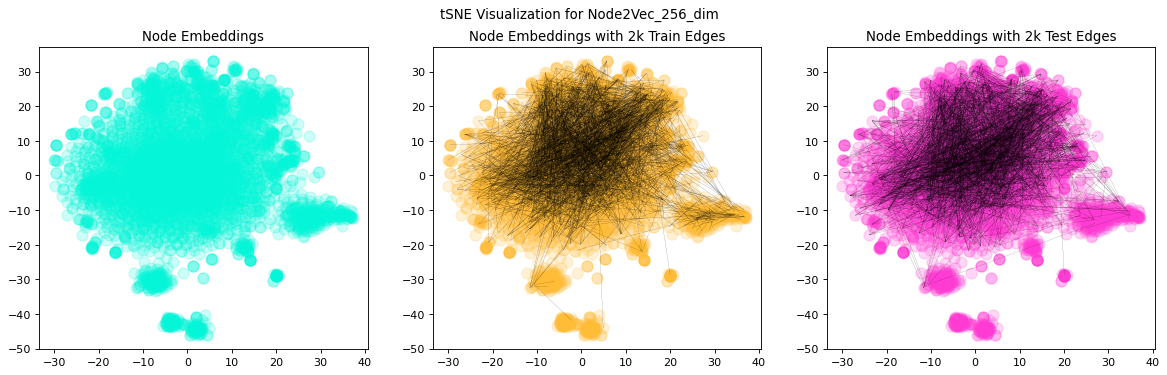

In [ ]:
filepath = 'training_outputs/train-embedding-256.pt' # Plot tSNE for Node2Vec embeddings
color = '#f794e9'
plot_tsne(filepath, 'Node2Vec_256_dim', color)

## tsne: GraphSAGE with random feature initialization

/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


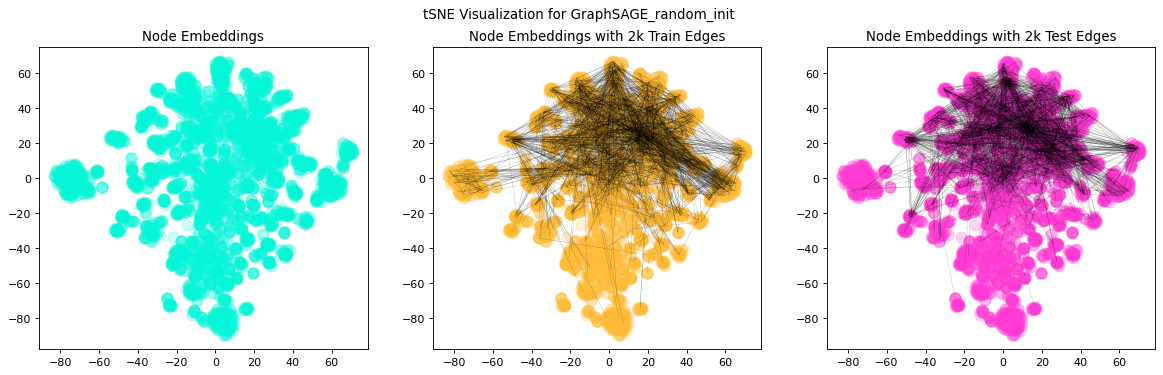

In [ ]:
# Plot GraphSAGE w. random feat emb
model_name = 'sage_rand_feat'
run = 0
filepath = f'training_outputs/{model_name}_final_emb_{run}.pt'
color = '#f794e9'
plot_tsne(filepath, 'GraphSAGE_random_init', color)

## tSNE: GraphSAGE with Node2Vec Feature Initialization

/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


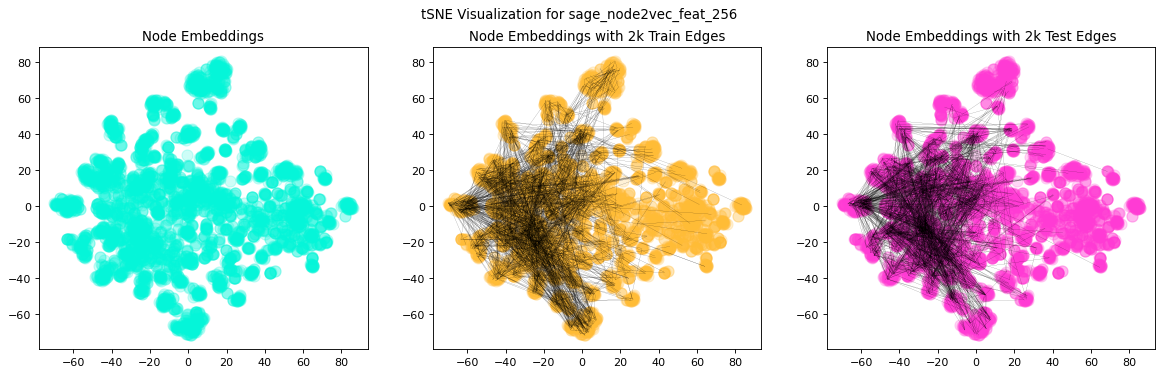

In [ ]:
model_name = 'sage_node2vec_feat_256'
run = 0
filepath = f'training_outputs/{model_name}_final_emb_{run}.pt'
color = '#f794e9'
plot_tsne(filepath, model_name, color)

## tSNE: GCN with Random Feature Initialization

/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


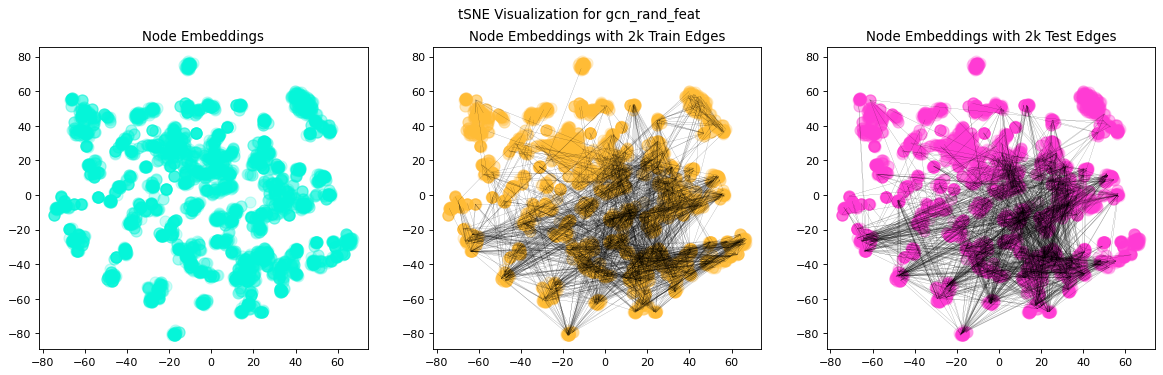

In [ ]:
model_name = 'gcn_rand_feat'
run = 0
filepath = f'training_outputs/{model_name}_final_emb_{run}.pt'
color = '#f794e9'
plot_tsne(filepath, model_name, color)

## tSNE: GCN with Node2Vec Feature Initialization

/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


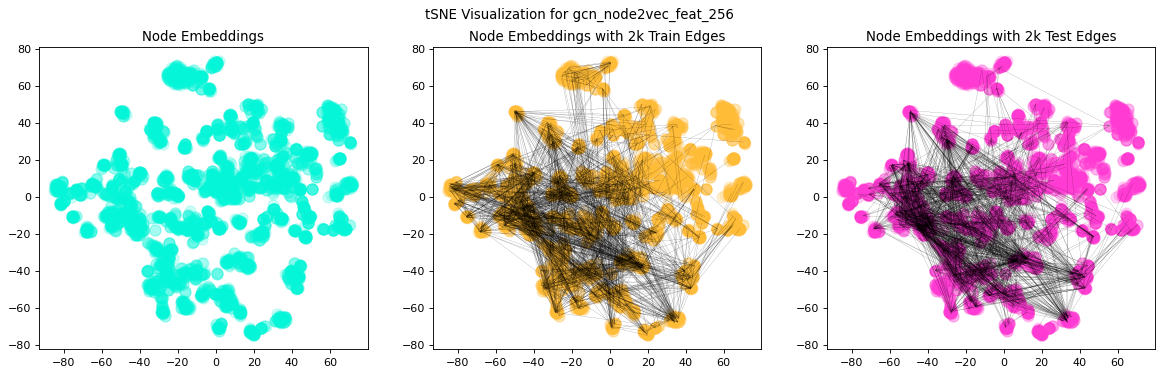

In [ ]:
model_name = 'gcn_node2vec_feat_256'
run = 0
filepath = f'training_outputs/{model_name}_final_emb_{run}.pt'
color = '#f794e9'
plot_tsne(filepath, model_name, color)

## tSNE: GIN with Random Feature Initialization

/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


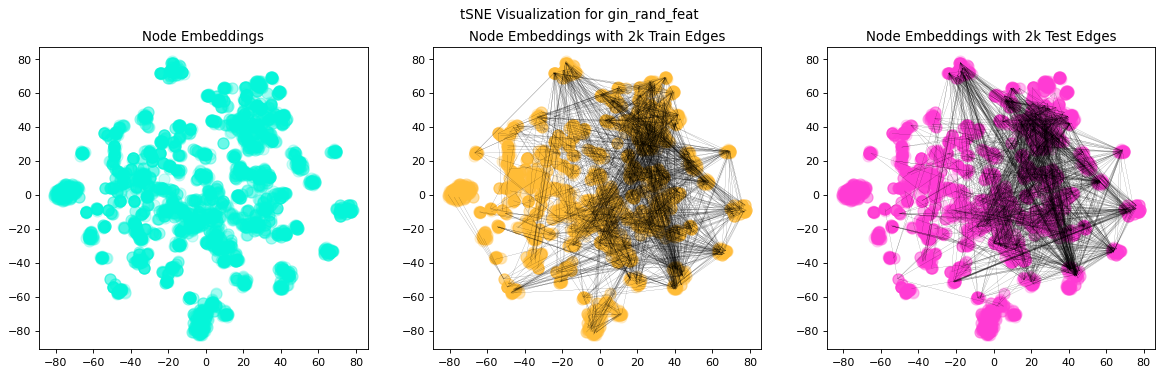

In [ ]:
model_name = 'gin_rand_feat'
run = 0
filepath = f'training_outputs/{model_name}_final_emb_{run}.pt'
color = '#f794e9'
plot_tsne(filepath, model_name, color)

## tSNE: GIN with Node2Vec Feature Initialization

/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/project3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


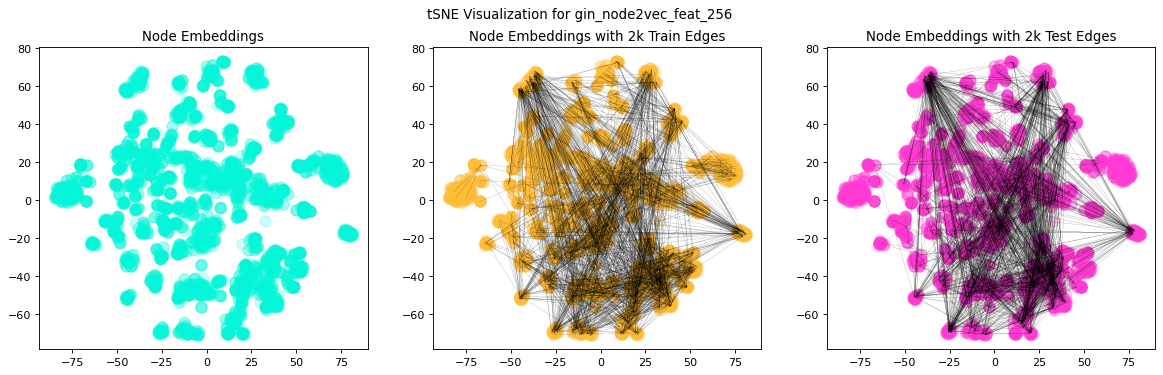

In [ ]:
model_name = 'gin_node2vec_feat_256'
run = 0
filepath = f'training_outputs/{model_name}_final_emb_{run}.pt'
color = '#f794e9'
plot_tsne(filepath, model_name, color)

## References

[1] Weihua Hu, Matthias Fey, Marinka Zitnik, Yuxiao Dong, Hongyu Ren, Bowen Liu, Michele Catasta, and Jure Leskovec. Open graph benchmark: Datasets for machine learning on graphs. 2020. 

[2] Aditya Grover and Jure Leskovec. node2vec: Scalable feature learning for networks. CoRR, abs/1607.00653, 2016.

[3] Thomas N. Kipf and Max Welling. Semi-supervised classification with graph convolutional networks. CoRR, abs/1609.02907, 2016.

[4] William L. Hamilton, Rex Ying, and Jure Leskovec. Inductive representation learning on large graphs. CoRR, abs/1706.02216, 2017.

[5] Keyulu Xu, Weihua Hu, Jure Leskovec, and Stefanie Jegelka. How powerful are graph neural networks? CoRR, abs/1810.00826, 2018.